# Introduction

This notebook tackles the [**Playground Series – Season 5, Episode 10: Predicting Road Accident Risk**](https://www.kaggle.com/competitions/playground-series-s5e10), a competition focused on a critical real-world problem: predicting the likelihood of road accidents. The goal is to develop a regression model that can accurately estimate accident\_risk based on a variety of road conditions, environmental factors, and historical data.

### Our Approach

To achieve this, we will follow a structured machine learning workflow:

1.  **Exploratory Data Analysis (EDA):** We will begin by conducting a deep dive into the dataset to understand its structure, identify patterns, and uncover relationships between features and the target variable. This includes analyzing feature distributions, correlations, and data quality.
    
2.  **Data Preprocessing & Feature Engineering:** Based on insights from the EDA, we will clean the data (e.g., handle duplicates) and engineer new features to enhance the predictive power of our model. This will involve encoding categorical variables and creating interaction terms.
    
3.  **Model Development:** We will build and train a robust predictive model. Given the tabular nature of the data, we will likely focus on gradient boosting models like LightGBM or XGBoost, which are known for their high performance in similar competitions.
    
4.  **Submission:** Finally, we will use our trained model to make predictions on the test set and generate a submission.csv file in the required format.
    

### Initial Findings from EDA

Our preliminary analysis has already revealed several key characteristics of the dataset:

*   **High-Quality Data:** The training and test sets are well-structured and contain **no missing values**, which simplifies the preprocessing stage.
    
*   **Consistent Distributions:** The feature distributions between the training and test sets are remarkably similar, suggesting that a model trained on this data should generalize well.
    
*   **Key Predictors:** curvature and speed\_limit have emerged as the features with the strongest positive correlation to accident\_risk.
    
*   **Potential Data Leakage:** The num\_reported\_accidents feature shows a correlation with the target and will be handled with care to avoid data leakage.
    

Let's begin by loading the necessary libraries and exploring the data.

# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)
3. [Data Visualization](#Data-Visualization)
4. [Training Dataset EDA](#Training-Dataset-EDA)
5. [Test Dataset EDA](#Test-Dataset-EDA)
6. [Examine Original Dataset](#Examine-Original-Dataset)
7. [Original Dataset EDA](#Original-Dataset-EDA)
8. [Dataset Comparison Report](#Dataset-Comparison-Report)
9. [Feature Engineering](#Feature-Engineering)
10. [Model Training](#Model-Training)
11. [Prepare Submission](#Prepare-Submission)

# Data Loading and Overview

In [1]:
!pip uninstall -y sweetviz
!pip install sweetviz

Found existing installation: sweetviz 2.3.1
Uninstalling sweetviz-2.3.1:
  Successfully uninstalled sweetviz-2.3.1
  Using cached sweetviz-2.3.1-py3-none-any.whl.metadata (24 kB)
Using cached sweetviz-2.3.1-py3-none-any.whl (15.1 MB)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
%pip install --no-binary lightgbm --config-settings=cmake.define.USE_CUDA=ON lightgbm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip -q install -U optuna
%pip -q install optuna-integration[lightgbm]


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip -q install --upgrade ydata_profiling


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# --- Standard library
import os
import sys
import math
import random
import warnings
from pathlib import Path
from contextlib import contextmanager
from time import time
from typing import Iterable
from IPython.display import display, Markdown, IFrame

# --- Third-party
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from ydata_profiling import ProfileReport
from pandas.api.types import (
    is_categorical_dtype,
    is_numeric_dtype,
    is_object_dtype,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn import set_config
set_config(transform_output="pandas")

import lightgbm as lgb

# --- Notebook settings
warnings.filterwarnings("ignore")

%matplotlib inline

In [6]:

# Define some utilities functions
def configure_notebook(seed: int = 10301, float_precision: int = 3, max_columns: int = 15, max_rows: int = 25) -> int:
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

# Use a context manager to suppress standard error output
# This is a robust way to handle warnings that bypass Python's warnings module
class SuppressStderr:
    def __enter__(self):
        self.original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.original_stderr

In [7]:
# Apply configuration and set random seeds for reproducibility
seed = configure_notebook(max_columns = None, max_rows = None)    

In [8]:
# Configurable flag to control whether GPU is used
USE_GPU = True

def resolve_lgb_device(use_gpu: bool, X: pd.DataFrame, y: pd.Series,
                        platform_id: int = -1, device_id: int = -1):
    """
    Returns a dict of LightGBM params for the chosen device.
    Tries OpenCL GPU -> CPU.
    """
    if not use_gpu:
        return {"device_type": "cpu", "force_col_wise": True}  # CPU-only hint

    try:
        probe = lgb.LGBMRegressor(
            n_estimators=10,
            device_type="gpu",
            max_bin=63,
            gpu_platform_id=platform_id, 
            gpu_device_id=device_id,
            verbosity=-1,
        )
        # tiny probe fit to validate the backend works
        _n = min(len(X), 2000)
        probe.fit(X.iloc[:_n], y.iloc[:_n])
        return {"device_type": "gpu", 
                "gpu_platform_id": platform_id, 
                "gpu_device_id": device_id}
    except Exception as e:
        print("OpenCL not available, falling back to CPU:", type(e).__name__, e)

    # Fall back to CPU
    return {"device_type": "cpu", "force_col_wise": True}

In [9]:
def eda_summary(df: pd.DataFrame) -> None:
    """
    Produce a concise, notebook-friendly Exploratory Data Analysis (EDA) summary.

    This utility prints and displays a standard set of diagnostics for a single
    DataFrame to help you quickly understand schema, completeness, and basic
    statistics. It is designed for use in Jupyter/IPython environments.

    The report includes:
      1. **First 5 rows** (transposed for vertical readability).
      2. **DataFrame info** (`df.info()`): dtypes and non-null counts.
      3. **Numeric describe** (`df.describe()`): count/mean/std/min/percentiles/max.
      4. **Categorical describe** (`df.select_dtypes(['object','category']).describe()`),
         or a note if none exist.
      5. **Missing values summary**: a table with per-column missing count and
         percentage of total rows.
      6. **Duplicate rows**: total number of duplicated records (`df.duplicated().sum()`).
      7. **Data types count**: frequency of each dtype in `df.dtypes`.
      8. **Correlation matrix** for numeric columns (if more than one numeric
         column exists), computed with Pearson correlation.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to summarize.

    Returns
    -------
    None
        Displays/prints the EDA sections and returns nothing.
    """
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe().T)
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


#### Read the training data and display a bit of it

In [10]:
DATA_DIR = Path('/kaggle/input/playground-series-s5e10') if running_in_kaggle() else Path('data')

training_df = pd.read_csv(DATA_DIR / 'train.csv')
training_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.060,35,daylight,rainy,False,True,afternoon,False,True,1,0.130
1,1,urban,4,0.990,35,daylight,clear,True,False,evening,True,True,0,0.350
2,2,rural,4,0.630,70,dim,clear,False,True,morning,True,False,2,0.300
3,3,highway,4,0.070,35,dim,rainy,True,True,morning,False,False,1,0.210
4,4,rural,1,0.580,60,daylight,foggy,False,False,evening,True,False,1,0.560


#### Read the test data and display it

In [11]:
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.340,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.040,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.590,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.950,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.860,35,daylight,clear,True,False,evening,False,True,3


#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [12]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.060,35,daylight,rainy,False,True,afternoon,False,True,1,0.130
1,urban,4,0.990,35,daylight,clear,True,False,evening,True,True,0,0.350
2,rural,4,0.630,70,dim,clear,False,True,morning,True,False,2,0.300
3,highway,4,0.070,35,dim,rainy,True,True,morning,False,False,1,0.210
4,rural,1,0.580,60,daylight,foggy,False,False,evening,True,False,1,0.560


In [13]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,highway,2,0.340,45,night,clear,True,True,afternoon,True,True,1
1,urban,3,0.040,45,dim,foggy,True,False,afternoon,True,False,0
2,urban,2,0.590,35,dim,clear,True,False,afternoon,True,True,1
3,rural,4,0.950,35,daylight,rainy,False,False,afternoon,False,False,2
4,highway,2,0.860,35,daylight,clear,True,False,evening,False,True,3


## Exploratory Data Analysis

In [14]:
# eda_summary(training_df)
profile = ProfileReport(training_df, title="Training EDA Report")
profile.to_file("training_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Display the HTML report in an iframe
IFrame(src='training_report.html', width=1000, height=600)

#### Show the statistics and structure of the test data

In [16]:
profile = ProfileReport(test_df, title="Test EDA Report")
profile.to_file("test_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.83it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Display the HTML report in an iframe
IFrame(src='test_report.html', width=1000, height=600)

# Data Visualization

#### Target & Feature distributions — What & why
We first examine the distribution of **accident_risk** and the marginal distributions of key numeric features.
This reveals central tendency, spread, skewness, and potential multi‑modality (e.g., half/double‑time clusters).
These insights inform scaling and simple transforms and guard against outlier‑driven RMSE errors.

In [18]:
TARGET = "accident_risk"
IS_CLASSIFICATION = training_df[TARGET].nunique() <= 10 and training_df[TARGET].dtype != float

In [19]:
def split_columns(df: pd.DataFrame, max_cardinality: int = 30):
    """
    Heuristic split into numeric vs categorical, with a cardinality cap for cats.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    
    # treat low-unique integer columns as categorical (IDs will be filtered later)
    for c in list(num_cols):
        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique(dropna=True) <= max_cardinality:
            cat_cols.append(c)
            num_cols.remove(c)
            
    # drop high-cardinality cats from categorical plotting by default
    low_card_cats = [c for c in cat_cols if df[c].nunique(dropna=True) <= max_cardinality]
    
    return num_cols, low_card_cats
    
# short axis label helper
def colname(v):
    return str(v).replace("_", " ").title()

In [20]:
def collapse_rare_categories(s: pd.Series, min_count: int = 50) -> pd.Series:
    vc = s.value_counts()
    keep = vc[vc >= min_count].index
    return s.where(s.isin(keep), other="__OTHER__")

In [21]:
def categorical_vs_target_classification(df: pd.DataFrame, feature, target, min_count = 50, top_n = 20):
    s = collapse_rare_categories(df[feature].astype("object"), min_count=min_count)
    d = pd.DataFrame({feature: s, target: df[target]}).dropna()
    grp = d.groupby(feature)
    counts = grp.size().sort_values(ascending=False).head(top_n)
    cats = counts.index

    rate = grp[target].mean().reindex(cats)

    # counts
    plt.figure(figsize=(8, max(2, 0.35 * len(cats))))
    plt.barh([str(c) for c in cats], counts.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Count"); plt.title(f"{feature} – Top {len(cats)} Counts")
    plt.show()

    # target rates
    plt.figure(figsize=(8, max(2, 0.35 * len(cats))))
    plt.barh([str(c) for c in cats], rate.values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Mean {target}"); plt.title(f"{feature} – Target Rate (Top {len(cats)})")
    plt.show()

In [22]:
def has_target(df: pd.DataFrame, target:str):
    return target is not None and target in df.columns

In [23]:
def numeric_by_category_trend(df: pd.DataFrame, xcol:str, cat:str, target:str = TARGET, q:int = 15, min_count:int = 2000):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Keep frequent categories to reduce noise
    keep = df[cat].value_counts()
    keep = keep[keep >= min_count].index
    for k in keep:
        d = df[df[cat] == k][[xcol, target]].dropna()
        if d.empty or d[xcol].nunique() <2 : 
            continue
            
        bins = pd.qcut(d[xcol], q = min(q, d[xcol].nunique()), duplicates = "drop")
        m = d.groupby(bins)[target].mean()

        idx = m.index
        try:
            centers = idx.mid.to_numphy()
        except AttributeError:
            # fallback for very old pandas
            centers = np.array([(iv.left + iv.right) * 0.5 for iv in idx])
            
    plt.plot(centers, m.values, label = str(k))
    plt.title(f"{xcol} → mean({target}) by {cat}")
    plt.xlabel(xcol); 
    plt.ylabel(f"Mean {target}")
    plt.legend(loc="best")
    plt.show()

In [24]:
def cat_cat_heatmap(df: pd.DataFrame, cat1:str, cat2:str, target:str = TARGET, min_count:int = 500):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[cat1, cat2, target]].dropna()
    g = d.groupby([cat1, cat2])[target].agg(["mean", "count"]).reset_index()
    g = g[g["count"] >= min_count]
    if g.empty:
        print(f"[info] No {cat1}×{cat2} cells with count >= {min_count}.")
        return

    # Normalize labels ONCE to consistent strings
    s1 = g[cat1].astype("string").fillna("<NA>").astype(str)
    s2 = g[cat2].astype("string").fillna("<NA>").astype(str)

    # Stable ordering (by label) or by frequency if preferred
    rows, r_codes = np.unique(s1, return_inverse = True)
    cols, c_codes = np.unique(s2, return_inverse = True)

    A = np.full((len(rows), len(cols)), np.nan, dtype = float)
    A[r_codes, c_codes] = g["mean"].to_numpy()

    plt.figure(figsize=(1.2 * len(cols) + 2, 1.2 * len(rows) + 2))
    im = plt.imshow(A, aspect = "auto", origin = "upper")
    cbar = plt.colorbar(im, fraction = 0.046, pad = 0.04, label = f"Mean {target}")
    plt.xticks(np.arange(len(cols)), cols, rotation = 45, ha = "right")
    plt.yticks(np.arange(len(rows)), rows)
    plt.title(f"{cat1} × {cat2} → mean({target})")
    plt.tight_layout()
    plt.show()

In [25]:
def numeric_numeric_hex(df: pd.DataFrame, x:str, y:str, target:str = TARGET, gridsize:int = 50):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[x, y, target]].dropna()
    plt.figure(figsize = (7, 5))
    hb = plt.hexbin(d[x].to_numpy(), d[y].to_numpy(), C=d[target].to_numpy(),
                    gridsize = gridsize, reduce_C_function = np.mean)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} × {y} → mean({target})")
    cb = plt.colorbar(hb)
    cb.set_label(f"Mean {target}")
    plt.show()

In [26]:
def time_of_day_vs_risk_line(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Time_of_day has discrete labels ("morning","afternoon","evening")
    order = ["morning", "afternoon", "evening"]
    d = df[["time_of_day","accident_risk"]].dropna()
    d = d[d["time_of_day"].isin(order)]
    g = d.groupby("time_of_day")["accident_risk"].mean().reindex(order)

    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(len(g)), g.values)
    plt.xticks(np.arange(len(g)), g.index, rotation = 0)
    plt.xlabel("time_of_day"); 
    plt.ylabel("Mean accident_risk"); 
    plt.title("Daily pattern")
    
    plt.show()

In [27]:
# Feature signal ranking without modeling
def show_feature_signal_ranking(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Spearman for numeric; ANOVA-style effect for categoricals
    num_cols = df.select_dtypes(include = [np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != target]

    scores = []
    for c in num_cols:
        s = df[[c, target]].dropna()
        if s.empty: continue
        rho, p = st.spearmanr(s[c], s[target])
        scores.append((c, float(rho)))
    scores = sorted(scores, key = lambda x: -abs(x[1]))
    print("Top numeric (|Spearman|):", scores[:10])

    cat_cols = [c for c in df.columns if c not in num_cols + [target]]
    effects = []
    for c in cat_cols:
        g = df.groupby(c, observed = True)[target].mean()
        if g.size >= 2:
            rng = float(g.max() - g.min())
            effects.append((c, rng, int(df[c].nunique())))
            
    effects = sorted(effects, key = lambda x: -x[1])
    print("Top categorical (range of mean risk):", effects[:10])

In [28]:
def plot_pairplot(df: pd.DataFrame, num_features: Iterable[str], target:str = TARGET):
    """
    Generates a pair plot for numerical features, colored by the target variable.
    """
    # Increase the 'height' parameter to make the overall plot larger.
    # A good starting point is around 3 to 5.
    sns.pairplot(df[num_features + [target]], hue=target, palette = 'viridis', height = 6)

    plt.suptitle('Pair Plot of Numerical Features', y=1.02)
    plt.show()
    
def plot_boxplots_grid(df: pd.DataFrame, cat_features: Iterable[str], target: str = TARGET, n_cols: int = 3):
    """
    Generates box plots for each categorical feature against the target variable
    in a n_cols -column grid.
    """
    # Define the grid dimensions
    n_features = len(cat_features)

    # Calculate the number of rows needed, using math.ceil to round up
    n_rows = math.ceil(n_features / n_cols)

    # Create the subplot grid
    # The figsize is increased to accommodate the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, n_rows * 5))

    # Flatten the axes array to make it easy to iterate over
    axes = axes.flatten()

    # Loop through the features and plot on the corresponding subplot
    for i, feature in enumerate(cat_features):
        ax = axes[i]
        sns.boxplot(x=feature, y=target, data=df, palette='viridis', ax = ax)
        ax.set_title(f'Box Plot of {target} by {feature}', fontsize = 12)
        ax.tick_params(axis = 'x', labelrotation = 45)

    # Hide any unused subplots
    # This is necessary if the number of features is not a perfect multiple of n_cols
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    # Adjust the layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()

def plot_violinplots_grid(df: pd.DataFrame, cat_features: Iterable[str], target:str = TARGET, n_cols: int = 3):
    """
    Generates violin plots for each categorical feature against the target variable.
    in a n_cols -column grid.
    """
    # Define the grid dimensions
    n_features = len(cat_features)

    # Calculate the number of rows needed, using math.ceil to round up
    n_rows = math.ceil(n_features / n_cols)

    # Create the subplot grid
    # The figsize is increased to accommodate the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, n_rows * 5))

    # Flatten the axes array to make it easy to iterate over
    axes = axes.flatten()

    # Loop through the features and plot on the corresponding subplot
    for i, feature in enumerate(cat_features):
        ax = axes[i]
        sns.violinplot(x=feature, y=target, data = df, palette = 'viridis', ax = ax)
        ax.set_title(f'Violin Plot of {target} by {feature}', fontsize = 12)
        ax.tick_params(axis = 'x', labelrotation = 45)

    # Hide any unused subplots
    # This is necessary if the number of features is not a perfect multiple of n_cols
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    # Adjust the layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()        

In [29]:
def is_discrete_numeric(s: pd.Series, max_unique:int = 20):
    return pd.api.types.is_numeric_dtype(s) and s.nunique(dropna = True) <= max_unique

def top_numeric_by_spearman(df: pd.DataFrame, num_cols: Iterable[str], target, k = 6):
    import scipy.stats as st
    scores = []
    for c in num_cols:
        d = df[[c, target]].dropna()
        if d.empty: 
            continue
            
        # skip all-constant / all-equal
        if d[c].nunique() < 2: 
            continue
            
        rho, _ = st.spearmanr(d[c], d[target])
        if np.isfinite(rho):
            scores.append((c, abs(float(rho))))
            
    scores.sort(key=lambda x: -x[1])
    return [c for c,_ in scores[:k]]

def top_categorical_by_range(df: pd.DataFrame, cat_cols: Iterable[str], target:str = TARGET, min_count:int = 200, k:int = 6):
    effects = []
    for c in cat_cols:
        d = df[[c, target]].dropna()
        if d.empty: 
            continue
            
        vc = d[c].value_counts()
        keep = set(vc[vc >= min_count].index)
        if not keep:
            continue
            
        m = d[d[c].isin(keep)].groupby(c)[target].mean()
        if m.size >= 2:
            effects.append((c, float(m.max() - m.min())))
            
    effects.sort(key=lambda x: -x[1])
    return [c for c,_ in effects[:k]]

In [30]:
def run_eda(df: pd.DataFrame, target: str, max_cat_card: int = 30,
            heavy_sample: int = 150_000, num_count: int = 10, cat_count = 10):
    """
    Compact EDA runner for mixed tabular data.
    - Uses new target-aware visuals when target is present.
    - Skips safely on test sets (no target).
    - Limits heavy plots to top-signal features.
    - Optionally downsamples for hexbin/heatmaps.
    """
    # Separate a version without target (works if target absent)
    df_wo_target = df.drop(columns = [target], errors = "ignore") if target else df

    # Split columns
    num_cols, cat_cols = split_columns(df_wo_target, max_cardinality = max_cat_card)
    
    # Treat booleans as categorical for plotting
    bool_cols = [c for c in df_wo_target.columns if pd.api.types.is_bool_dtype(df_wo_target[c])]
    cat_cols = sorted(set(cat_cols).union(bool_cols))

    # Target-aware (only if target present)
    if not has_target(df, target):
        print("Target not present → skipping target-aware plots.")
        return

    y = df[target]
    is_regression = pd.api.types.is_numeric_dtype(y) and y.nunique(dropna = True) > 20

    # Choose top features to keep plots readable and fast
    if is_regression:
        top_nums = top_numeric_by_spearman(df, [c for c in num_cols if c != target], target, k = num_count) or num_cols[:num_count]
        top_cats = top_categorical_by_range(df, cat_cols, target, min_count = 200, k = cat_count) or cat_cols[:cat_count]

        # Pair plots
        display(Markdown("### Pair Plots"))
        plot_pairplot(df, top_nums, target)

        # Box plots
        # Since violin plots show the same, skipping boxplots for now.
        # display(Markdown("### Box Plots"))
        # plot_boxplots_grid(df, top_cats, target)

        # Violin plots
        display(Markdown("### Violin Plots"))
        plot_violinplots_grid(df, top_cats, target)

        # Interactions (small set)
        # numeric × categorical (trend by category)
        if top_nums and top_cats:
            display(Markdown("### Numeric × Categorical (Trend By Category)"))
            numeric_by_category_trend(df, top_nums[0], top_cats[0], target = target, q = 15, min_count = 3000)

        # categorical × categorical (heatmap)
        if len(top_cats) >= 2:
            display(Markdown("### Categorical × Categorical (Heatmap)"))
            cat_cat_heatmap(df, top_cats[0], top_cats[1], target = target, min_count = 1000)

        # numeric × numeric (hexbin target mean)
        if len(top_nums) >= 2:
            display(Markdown("### Numeric × Numeric (Hexbin Target Mean)"))
            d_hex = df
            if heavy_sample is not None and len(df) > heavy_sample:
                d_hex = df.sample(heavy_sample, random_state = seed)
            numeric_numeric_hex(d_hex, top_nums[0], top_nums[1], target = target, gridsize = 50)

    else:
        # Classification-style (few unique target values)
        top_nums = [c for c in num_cols if c != target][:6]
        top_cats = cat_cols[:6]

        for c in top_nums:
            try:
                numeric_vs_target_classification(df, c, target)
            except Exception as e:
                print(f"[warn] numeric(classif) plot failed for {c}: {e}")

        for c in top_cats:
            try:
                categorical_vs_target_classification(df, c, target, min_count = 100, top_n = 20)
            except Exception as e:
                print(f"[warn] categorical(classif) plot failed for {c}: {e}")

        # A couple of interactions
        if len(top_nums) and len(top_cats):
            display(Markdown("### Numeric x Category Trend"))
            numeric_by_category_trend(df, top_nums[0], top_cats[0], target = target, q = 12, min_count = 3000)
        if len(top_cats) >= 2:
            display(Markdown("### Category x Category Trend"))
            cat_cat_heatmap(df, top_cats[0], top_cats[1], target = target, min_count = 1500)

    # Display time of day vs risk line
    display(Markdown("### Time of Day vs Risk Line"))
    time_of_day_vs_risk_line(df)

    display(Markdown("### Feature Signal Ranking"))
    show_feature_signal_ranking(df)


## Training Dataset EDA

### Pair Plots

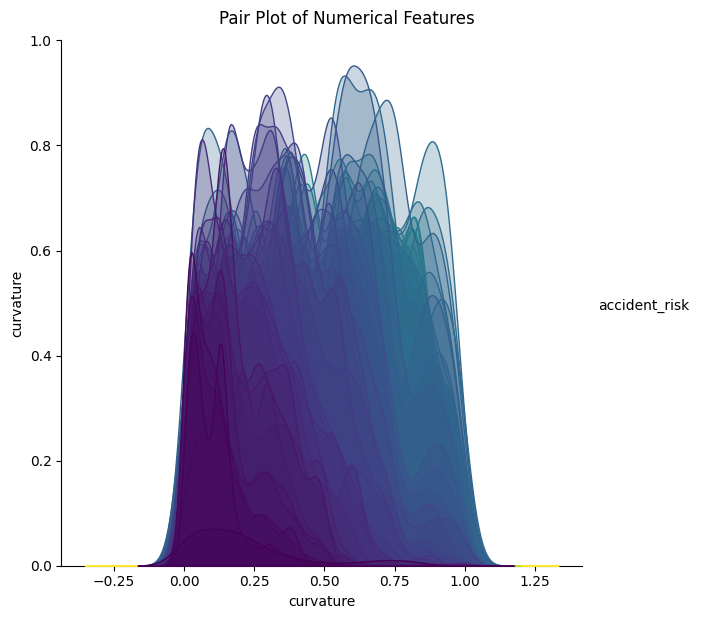

### Violin Plots

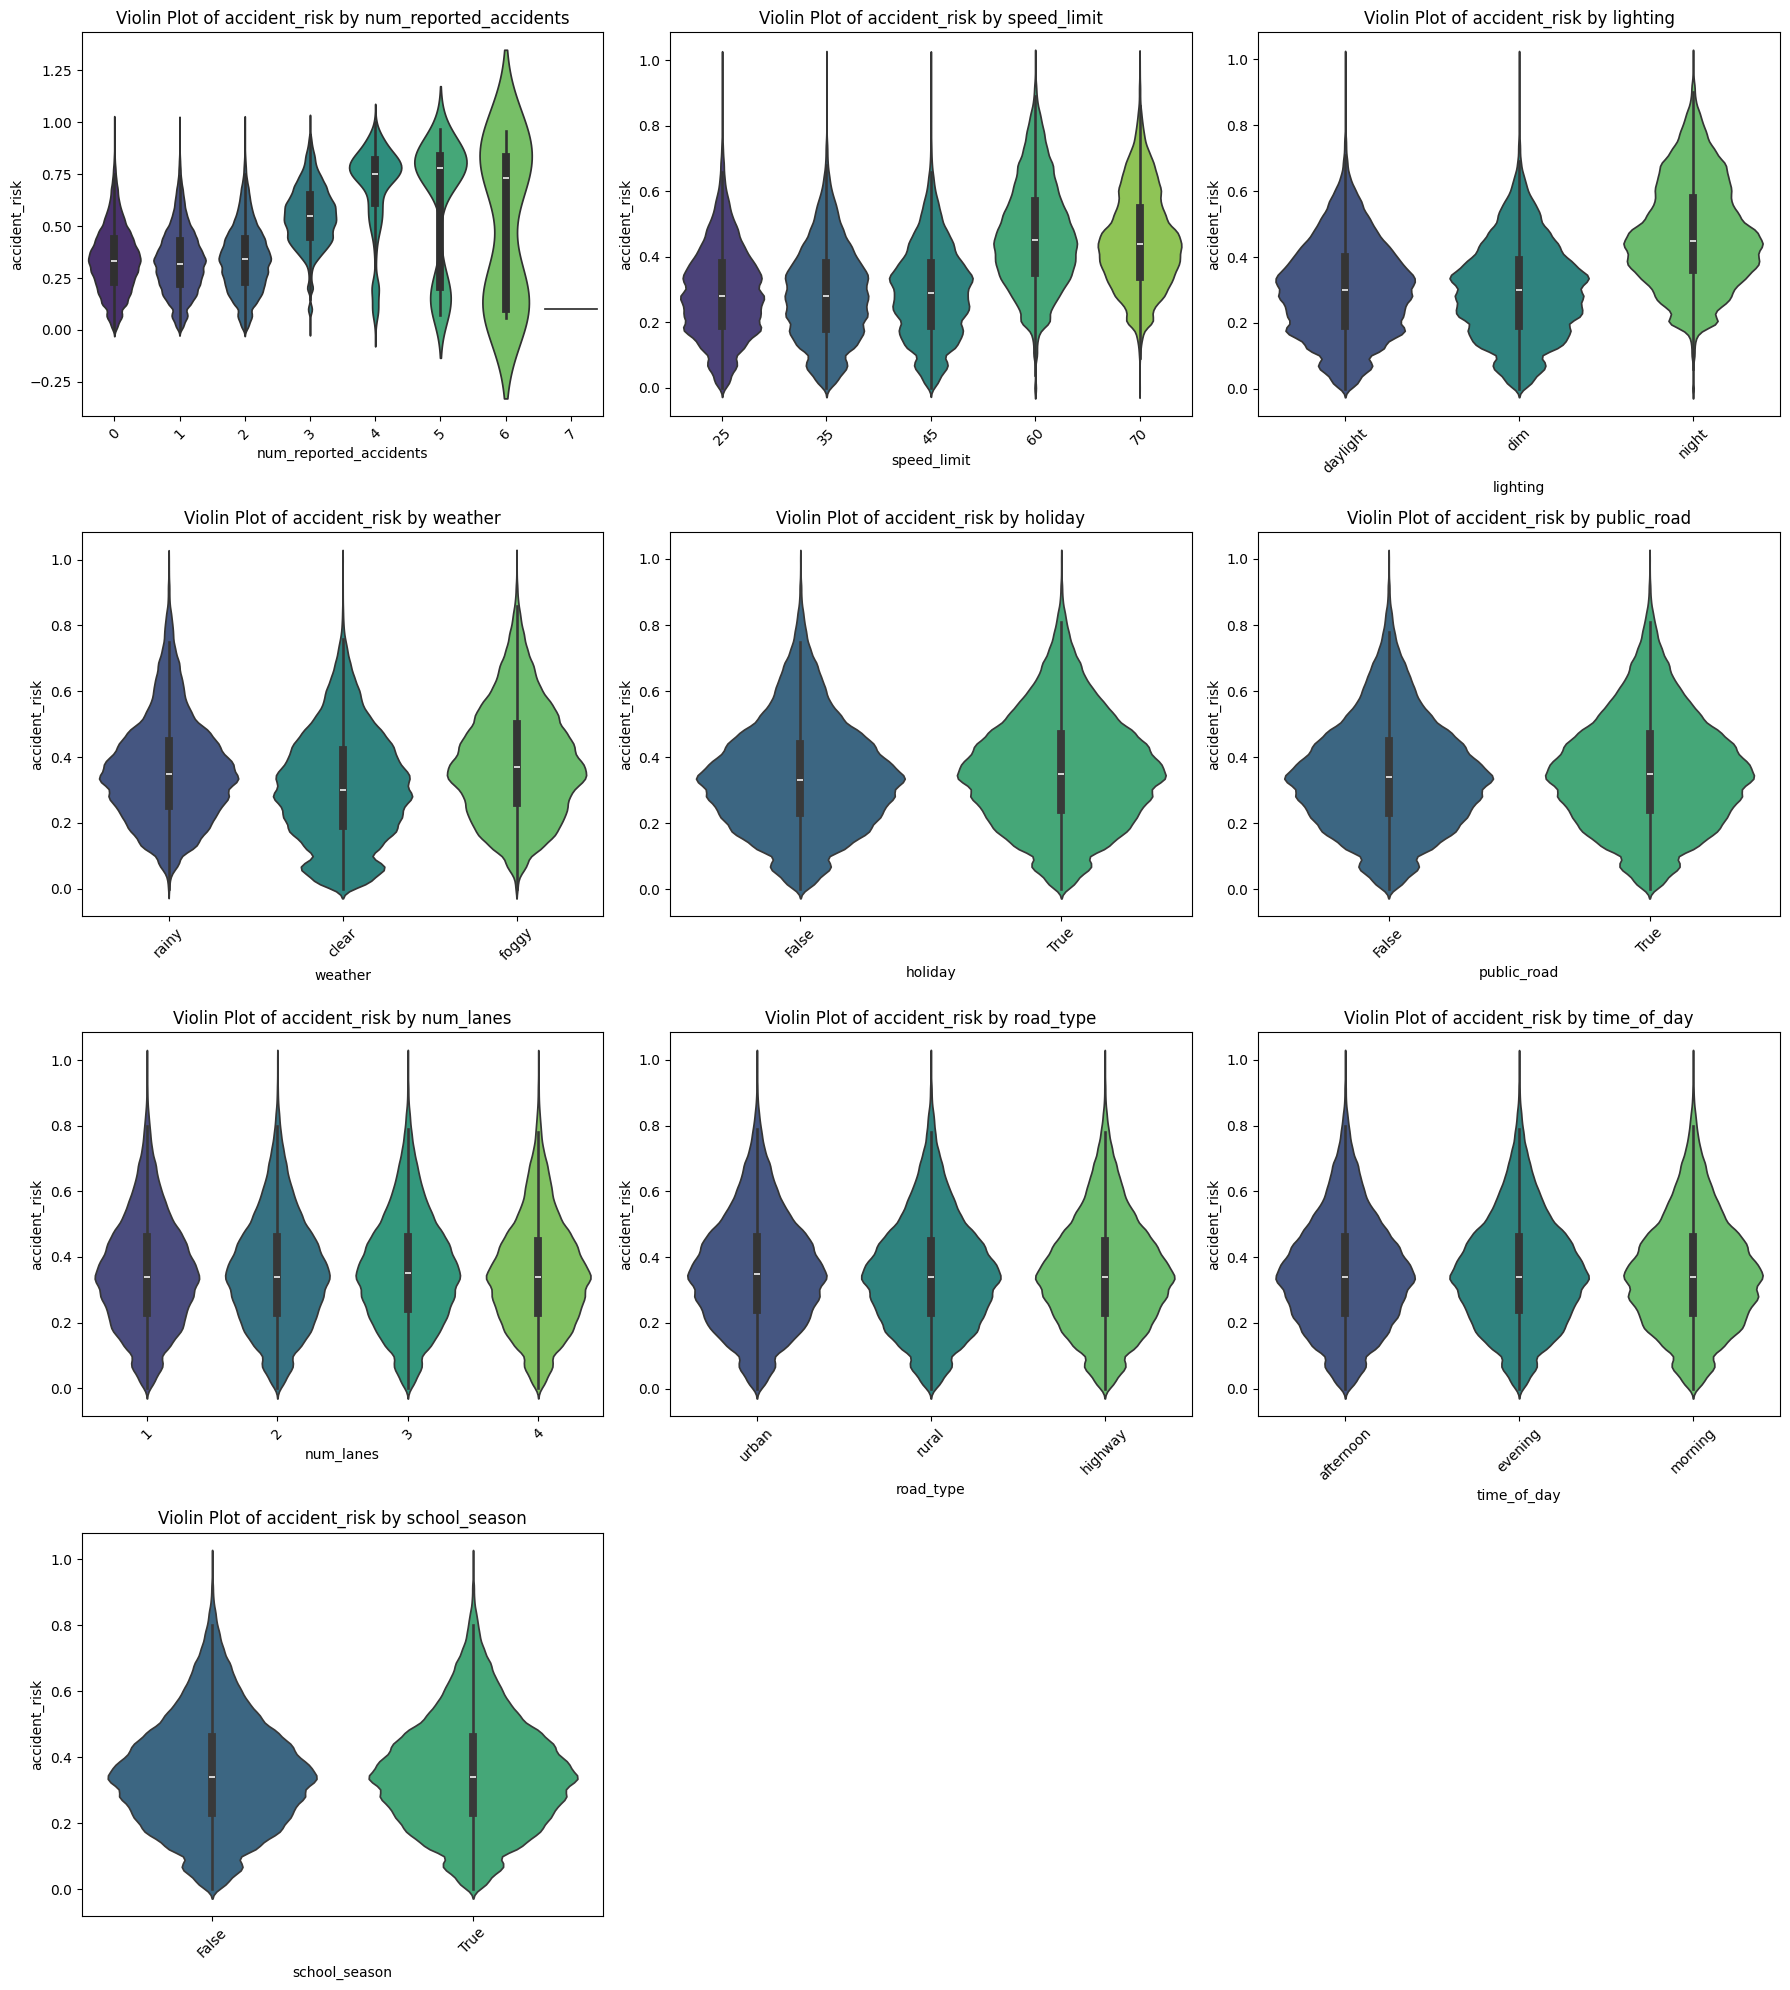

### Numeric × Categorical (Trend By Category)

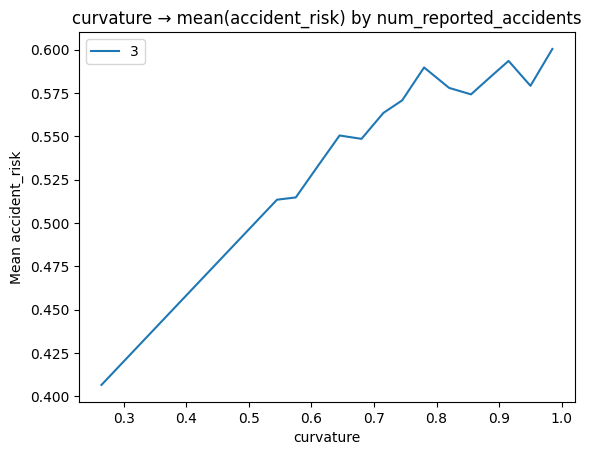

### Categorical × Categorical (Heatmap)

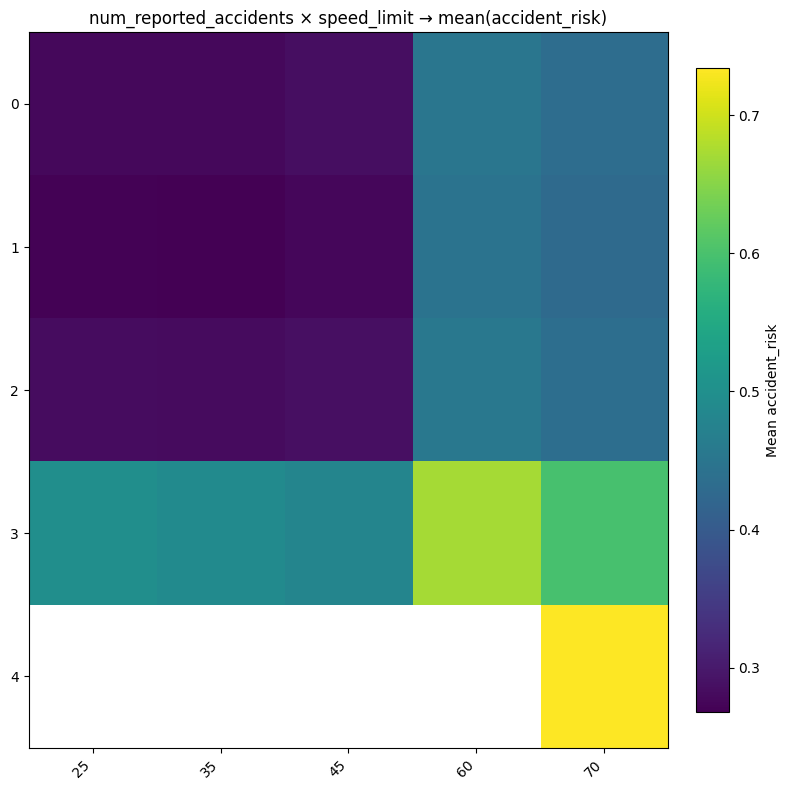

### Time of Day vs Risk Line

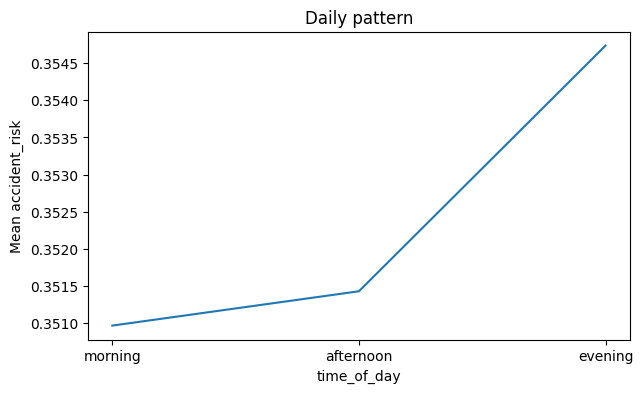

### Feature Signal Ranking

Top numeric (|Spearman|): [('curvature', 0.5467742572078576), ('speed_limit', 0.40914437276337084), ('num_reported_accidents', 0.15426290391245698), ('num_lanes', -0.007230978036206295)]
Top categorical (range of mean risk): [('lighting', 0.1703579791069305, 3), ('weather', 0.07624463499104406, 3), ('holiday', 0.017017868121310176, 2), ('public_road', 0.010328730695673638, 2), ('road_type', 0.007721712947188375, 3), ('time_of_day', 0.003769930463624338, 3), ('school_season', 0.0003251453185004194, 2), ('road_signs_present', 0.00020947831427381436, 2)]


In [31]:
run_eda(training_df, target = TARGET, max_cat_card = 30)

## Test Dataset EDA

In [32]:
run_eda(test_df, target = TARGET, max_cat_card = 30)

Target not present → skipping target-aware plots.


## Examine Original Dataset

In [33]:
ORIGINAL_DIR = Path("/kaggle/input/simulated-roads-accident-data") if running_in_kaggle() else Path("original_data")

original_df = pd.read_csv(ORIGINAL_DIR / 'synthetic_road_accidents_100k.csv')
original_df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.290,70,night,rainy,False,True,evening,False,False,1,0.640
1,highway,1,0.340,25,dim,clear,False,False,morning,False,False,3,0.270
2,rural,2,0.760,70,night,foggy,True,False,evening,True,True,1,0.760
3,rural,3,0.370,70,night,foggy,True,False,morning,False,True,0,0.600
4,highway,3,0.390,45,dim,rainy,False,True,morning,False,False,0,0.170


## Original Dataset EDA

### Pair Plots

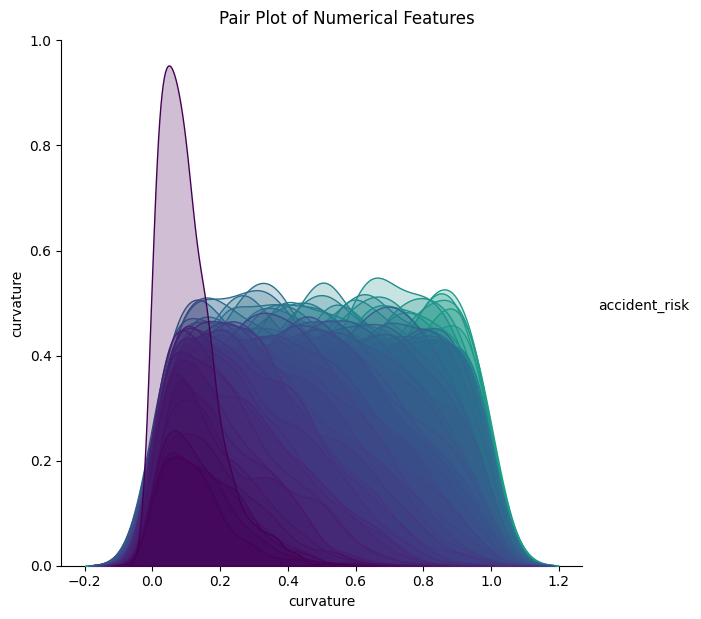

### Violin Plots

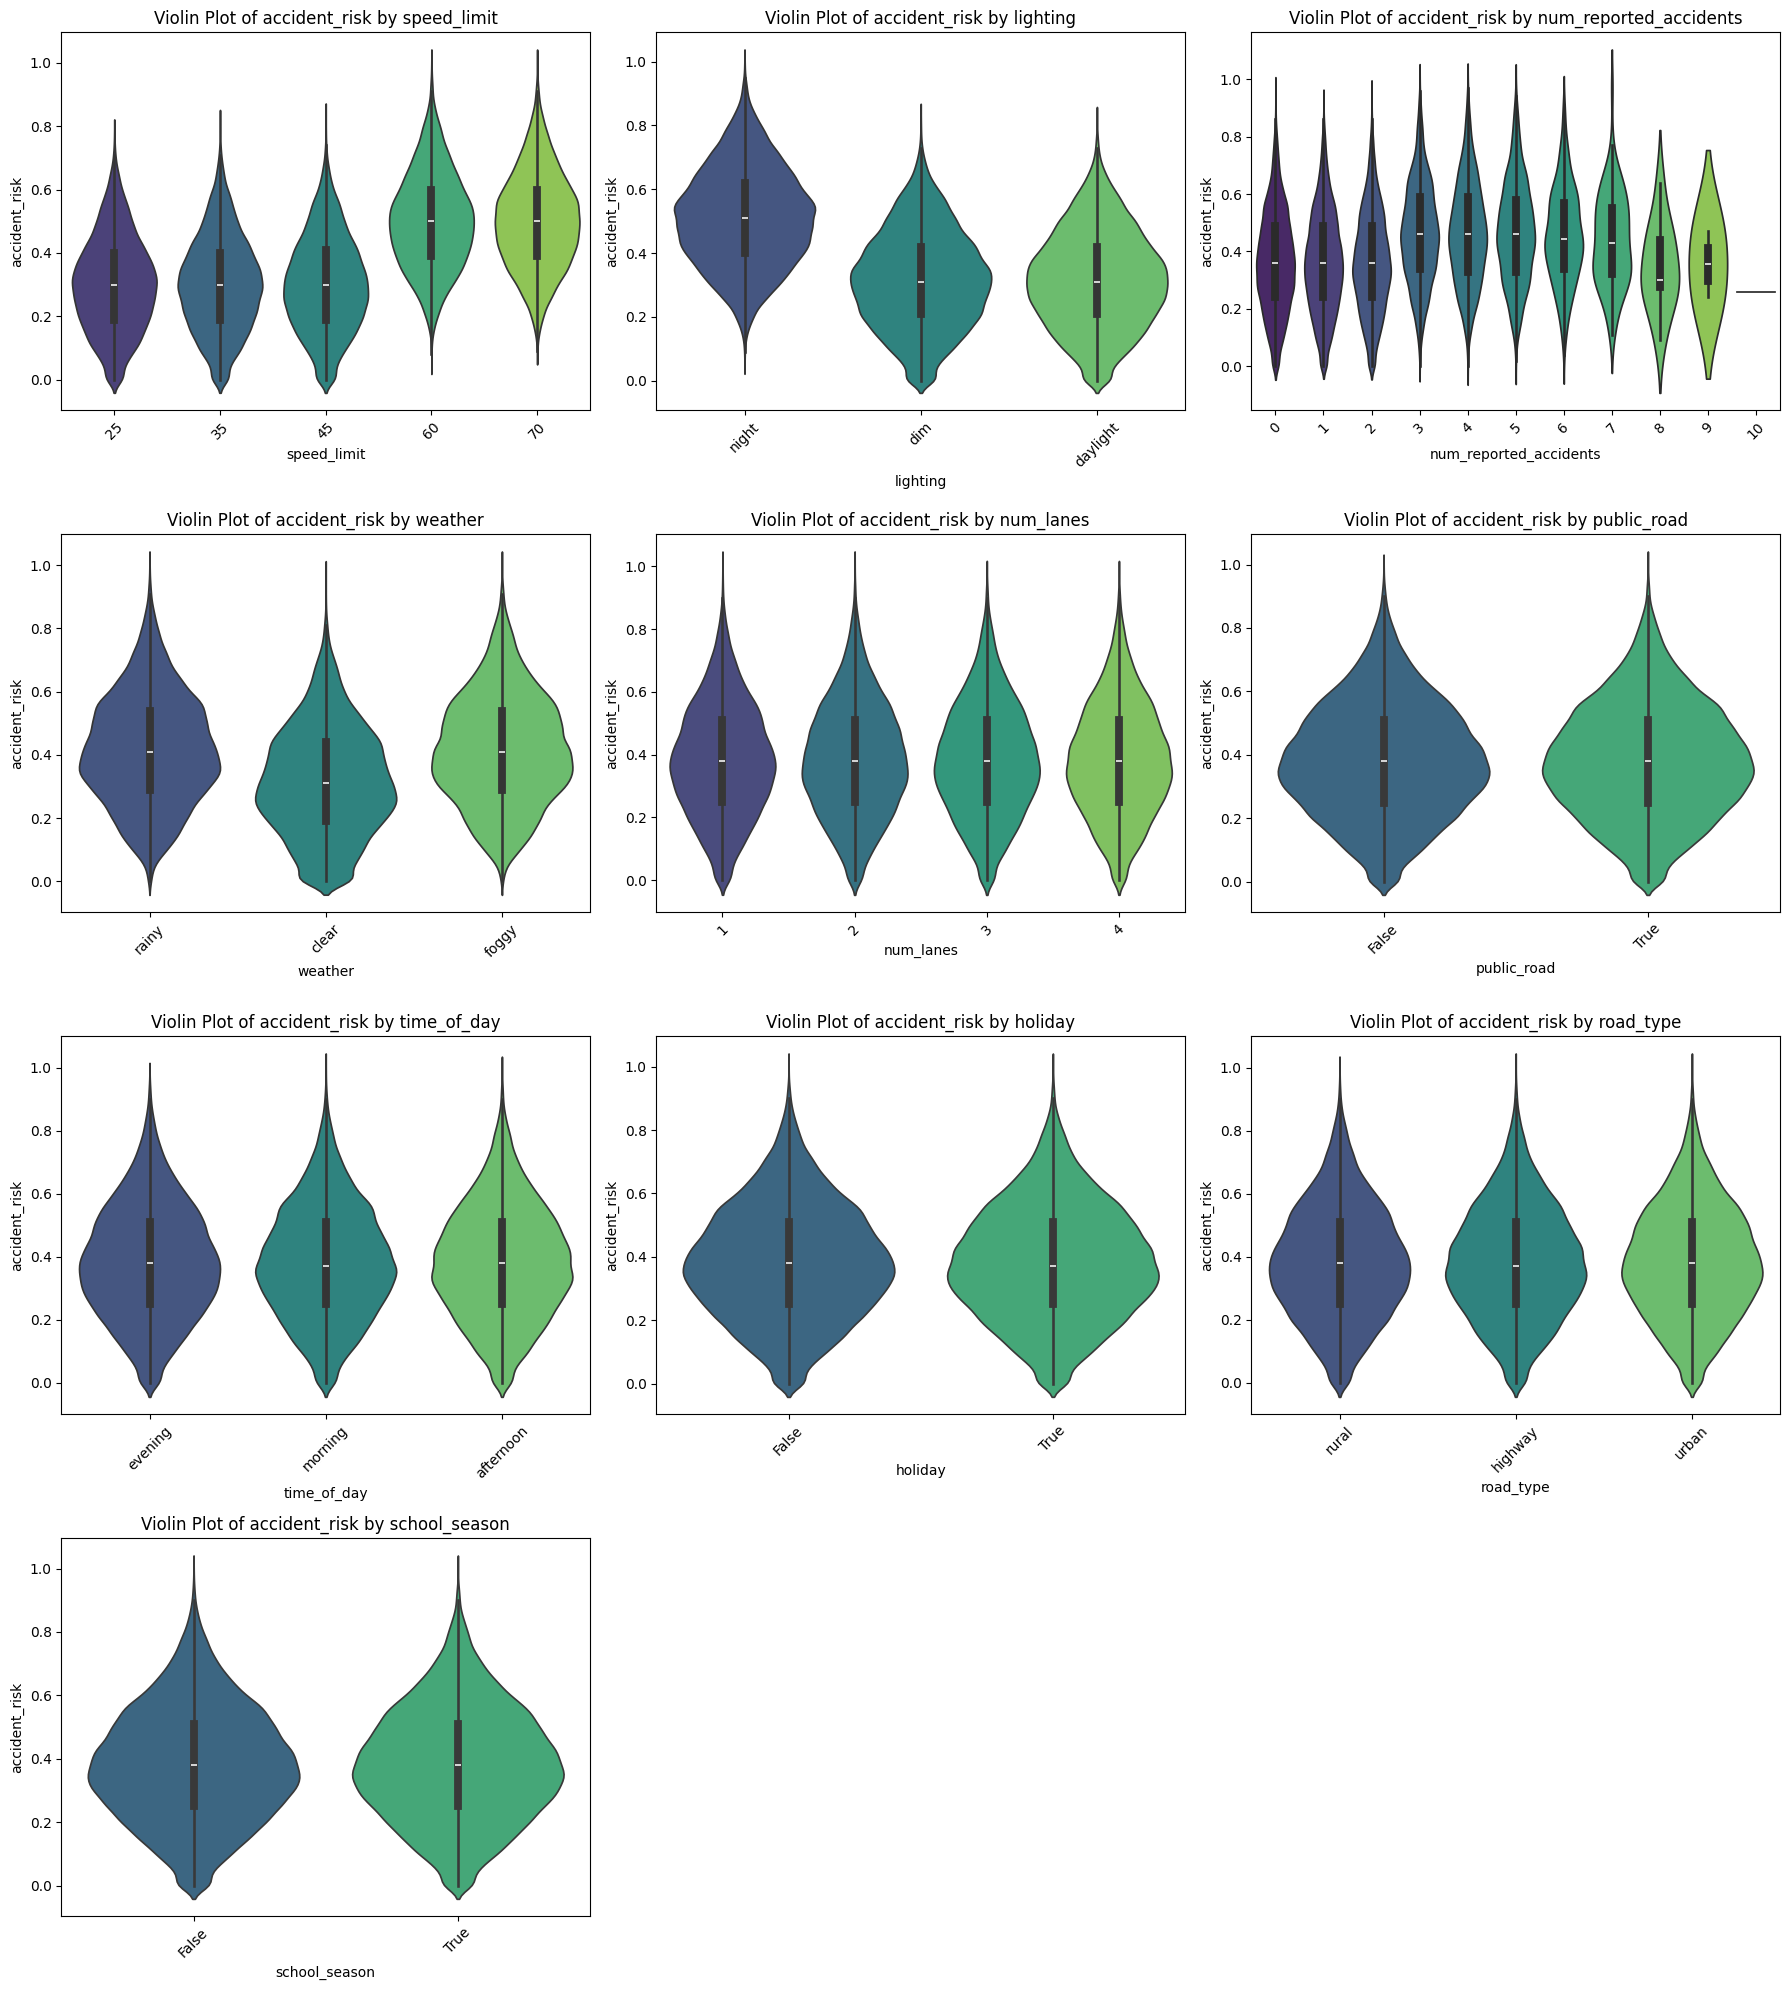

### Numeric × Categorical (Trend By Category)

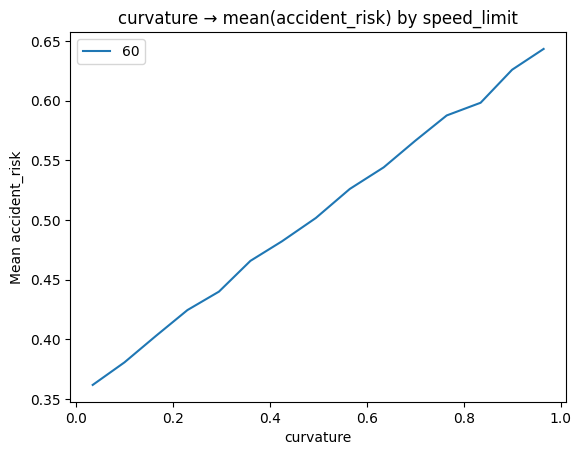

### Categorical × Categorical (Heatmap)

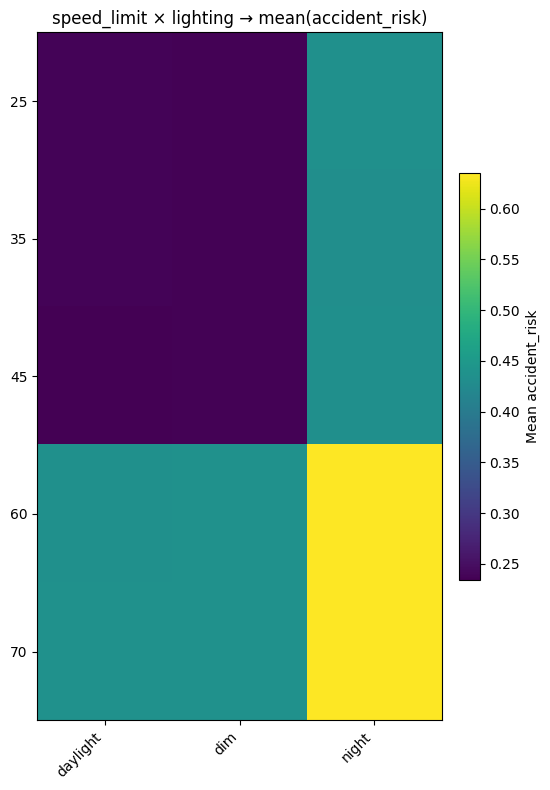

### Time of Day vs Risk Line

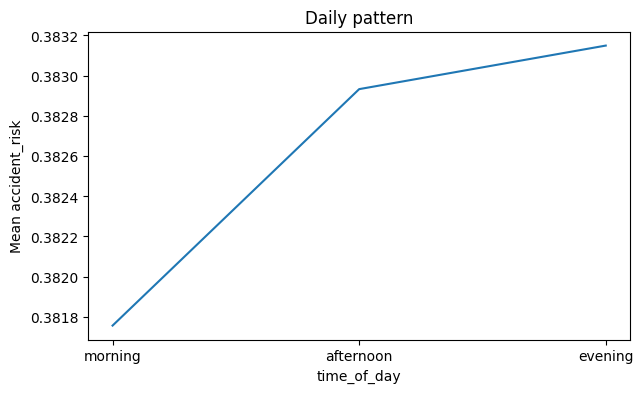

### Feature Signal Ranking

Top numeric (|Spearman|): [('speed_limit', 0.4755381706437699), ('curvature', 0.4694321426363731), ('num_reported_accidents', 0.14849663923552892), ('num_lanes', 0.0015855889200950967)]
Top categorical (range of mean risk): [('lighting', 0.197170074415491, 3), ('weather', 0.09975717725890859, 3), ('public_road', 0.0016333563844195265, 2), ('time_of_day', 0.001393338501637309, 3), ('holiday', 0.0013072121613361132, 2), ('road_type', 0.0007169961157473814, 3), ('school_season', 0.0005527101733853179, 2), ('road_signs_present', 0.00016134600929357257, 2)]


In [34]:
run_eda(original_df, target=TARGET, max_cat_card=30)

### Feature distributions

## Dataset Comparison Report

The exploratory data analysis reveals that the training and test datasets are remarkably similar, which is excellent for building a generalizable model. Here's a breakdown of the comparison:

*   **Data Structure and Quality**:
    
    *   Both datasets are clean with **no missing values**.
        
    *   The column types and feature names are consistent between the two sets (with the obvious exception of the accident\_risk target variable in the test set).
        
    *   Both datasets contain a small number of **duplicate rows** (656 in training, 1203 in testing). The training dupes might need to be removed before training to prevent any data leakage or bias.
        
*   **Feature Distributions**:
    
    *   **Numerical Features**: The distributions of curvature, speed\_limit, num\_lanes, and num\_reported\_accidents are nearly identical across both the training and test sets. The summary statistics (mean, std, min, max, etc.) are also very closely aligned. This indicates that the test set is a representative sample of the training data.
        
    *   **Categorical Features**: The value counts for categorical features like road\_type, lighting, weather, and time\_of\_day show very similar proportions in both datasets. There is no significant drift in the categorical distributions, which is favorable for model training.
        
    *   **Boolean Features**: Similarly, the boolean features (road\_signs\_present, public\_road, holiday, school\_season) have comparable distributions of True and False values.
        
*   **Correlations and Relationships**:
    
    *   The correlation matrices for the numerical features in both datasets are very similar. The relationships between features like curvature, speed\_limit, and num\_reported\_accidents are consistent.
        
    *   The box plots, violin plots, and pair plots on the training data reveal clear relationships between several features and the accident\_risk. Since the feature distributions are so similar in the test set, we can infer that these relationships will likely hold, which is a positive indicator for the model's predictive power.
        

In summary, the high degree of similarity between the training and test datasets suggests that a model trained on this data should perform well on the unseen test data without needing complex adjustments for distribution shifts

## Feature Engineering

Based on the EDA, here are some suggested next steps for feature engineering to enhance a model's performance:

1.  **Handle Categorical Features**:
    
    *   The categorical features (road\_type, lighting, weather, time\_of\_day) have low cardinality. **One-hot encoding** is a suitable approach here.
        
2.  **Create Interaction Features**:
    
    *   The EDA shows that curvature and speed\_limit are the two features most strongly correlated with accident\_risk. It's highly likely that their interaction is also significant.
        
    *   Consider other potentially meaningful interactions, especially between numerical and categorical features. For example, the effect of curvature might be different on a highway versus a rural road.
        
3.  **Polynomial Features**:
    
    *   Since curvature and speed\_limit show strong, somewhat linear relationships with the target, we should explore creating polynomial features from them to capture any non-linear effects. sklearn.preprocessing.PolynomialFeatures is a good tool for this.
        
4.  **Address the Leaky Feature**:
    
    *   The num\_reported\_accidents feature is a potential source of data leakage, as it's correlated with the target. While it's not a perfect predictor (meaning it's "leaky" rather than a direct spoiler), we should use it with caution. Here are a couple of strategies:
        
        *   **Drop the feature**: The simplest approach is to remove it entirely to avoid any risk of leakage.
            
        *   **Feature Engineering**: Create aggregate features from it. For example, we could calculate the average accident\_risk per num\_reported\_accidents in the training set and then use this as a new feature. Be careful to do this in a way that doesn't leak target information during cross-validation.
            
5.  **Binning Numerical Features**:
    
    *   While the relationships appear fairly linear, we could experiment with binning some of the numerical features, like speed\_limit, into categories (e.g., 'low', 'medium', 'high'). This can sometimes help tree-based models identify more distinct patterns.
        
6.  **Time-Based Features**:
    
    *   The time\_of\_day feature is categorical, but we could also treat it as an ordered feature. Given the daily pattern observed in the "Time of Day vs Risk" plot, we could encode it numerically (e.g., morning=1, afternoon=2, evening=3) to see if that captures the trend better for some models.

In [35]:
def safe_quantile_bins(s: pd.Series, bins, labels):
    s = s.astype(float)
    # Fallback if no variation or too few rows
    if s.nunique(dropna=True) < 2 or len(s) < 6:
        mid = labels[len(labels)//2]
        return pd.Series([mid] * len(s), index=s.index, dtype="object")
    # Try quantile cut; if it still fails, use the fallback
    try:
        return pd.qcut(s, q=bins, labels=labels, duplicates="drop").astype("object")
    except ValueError:
        mid = labels[len(labels)//2]
        return pd.Series([mid] * len(s), index=s.index, dtype="object")

In [36]:
# Identify Feature Types
# Instead of one-hot encoding, we'll tell LightGBM which columns are categorical.
categorical_features = [
    'road_type', 'lighting', 'weather', 'time_of_day', 'holiday_x_lighting',
    'weather_lighting', 'curvature_bin', 'speed_x_curvature_bin'
]

def feature_engineer(df: pd.DataFrame, target: str = TARGET, drop_duplicates:bool = True) -> pd.DataFrame:
    """
    Applies feature engineering steps to the road accident dataset.

    Args:
        df (pd.DataFrame): The input DataFrame (either training or test data).

    Returns:
        pd.DataFrame: The DataFrame with engineered features.
    """
    # Make a copy to avoid modifying the original DataFrame
    df_engineered = df.copy()

    # If requested, remove any duplicate rows
    if drop_duplicates:
        df_engineered = df_engineered.drop_duplicates()
    
    # The num_reported_accidents is impossible to derive when in production, and it's leaky, too.  Drop it.
    # df_engineered = df_engineered.drop('num_reported_accidents', axis=1)
    
    # Create Interaction Features
    # Interaction between speed limit and road curvature
    # Add a small epsilon to curvature to prevent division by zero
    df_engineered['speed_curvature_ratio'] = df_engineered['speed_limit'] / (df_engineered['curvature'] + 1e-6)

    # Combined environmental conditions
    df_engineered['weather_lighting'] = df_engineered['weather'].astype(str) + '_' + df_engineered['lighting'].astype(str)

    # Binning Curvature
    # Create categorical bins for the curvature feature.
    # The quantiles are chosen to split the data into meaningful groups.
    df_engineered['curvature_bin'] = safe_quantile_bins(
        df_engineered['curvature'],
        [0, 0.25, 0.75, 1.0],
        ['low', 'medium', 'high']
    ).astype(str)

    # Create Polynomial Features
    # Squaring the most correlated features to capture non-linear relationships
    df_engineered['curvature_sq'] = df_engineered['curvature'] ** 2
    df_engineered['speed_limit_sq'] = df_engineered['speed_limit'] ** 2

    # More Advanced Interactions
    # Interact the new curvature bins with the speed limit.
    df_engineered['speed_x_curvature_bin'] = df_engineered['speed_limit'].astype(str) + '_' + df_engineered['curvature_bin']

    # Time-based Interactions
    # The effect of lighting might differ on a holiday.
    df_engineered['holiday_x_lighting'] = df_engineered['holiday'].astype(str) + '_' + df_engineered['lighting'].astype(str)

    # Convert boolean features to integers for the model
    bool_cols = df_engineered.select_dtypes(include='bool').columns
    df_engineered[bool_cols] = df_engineered[bool_cols].astype(int)

    # Convert categorical columns to the 'category' dtype for LightGBM
    for col in categorical_features:
        df_engineered[col] = df_engineered[col].astype('category')

    return df_engineered

In [37]:
# Define hoe to treat all training dataset duplicates.
DROP_TRAINING_DUPLICATES = False

X_training = feature_engineer(training_df, drop_duplicates = DROP_TRAINING_DUPLICATES)

# Separate the target from the data, but leave it in for EDA
y_training = X_training[TARGET].copy()

X_test = feature_engineer(test_df, drop_duplicates = False)

In [38]:
X_training.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,speed_curvature_ratio,weather_lighting,curvature_bin,curvature_sq,speed_limit_sq,speed_x_curvature_bin,holiday_x_lighting
0,urban,2,0.060,35,daylight,rainy,0,1,afternoon,0,1,1,0.130,583.324,rainy_daylight,low,0.004,1225,35_low,False_daylight
1,urban,4,0.990,35,daylight,clear,1,0,evening,1,1,0,0.350,35.353,clear_daylight,high,0.980,1225,35_high,True_daylight
2,rural,4,0.630,70,dim,clear,0,1,morning,1,0,2,0.300,111.111,clear_dim,medium,0.397,4900,70_medium,True_dim
3,highway,4,0.070,35,dim,rainy,1,1,morning,0,0,1,0.210,499.993,rainy_dim,low,0.005,1225,35_low,False_dim
4,rural,1,0.580,60,daylight,foggy,0,0,evening,1,0,1,0.560,103.448,foggy_daylight,medium,0.336,3600,60_medium,True_daylight


### Examine the Engineered Training Dataset

### Pair Plots

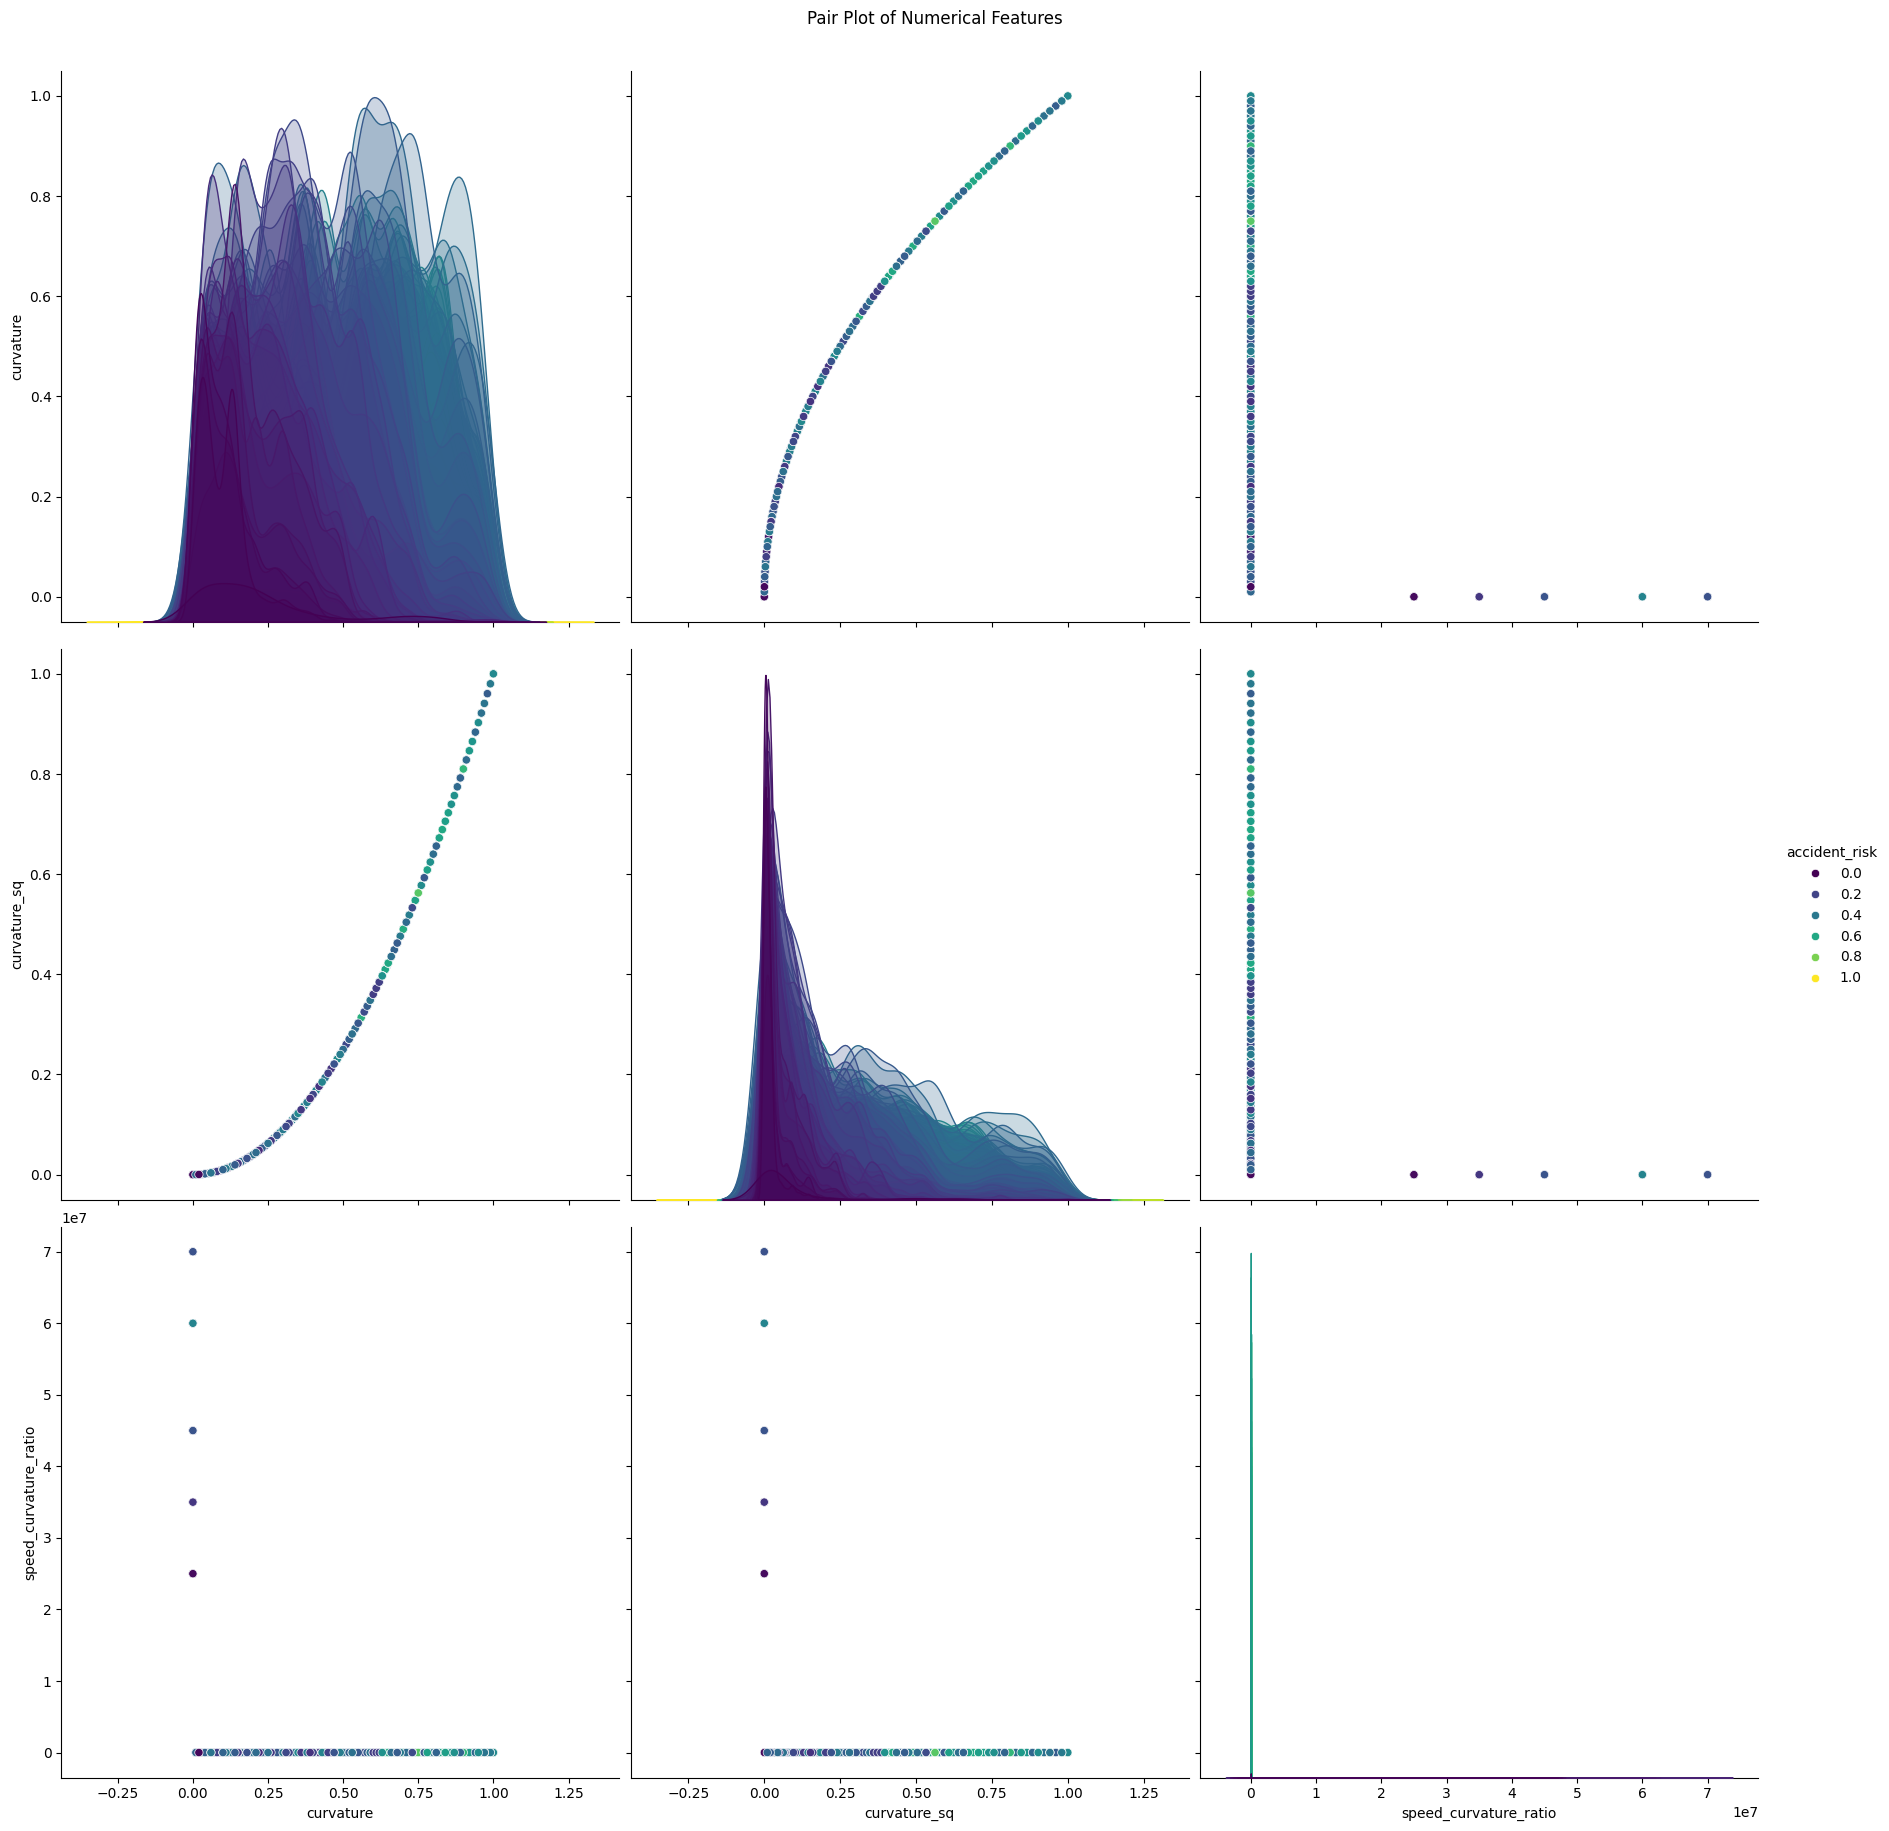

### Violin Plots

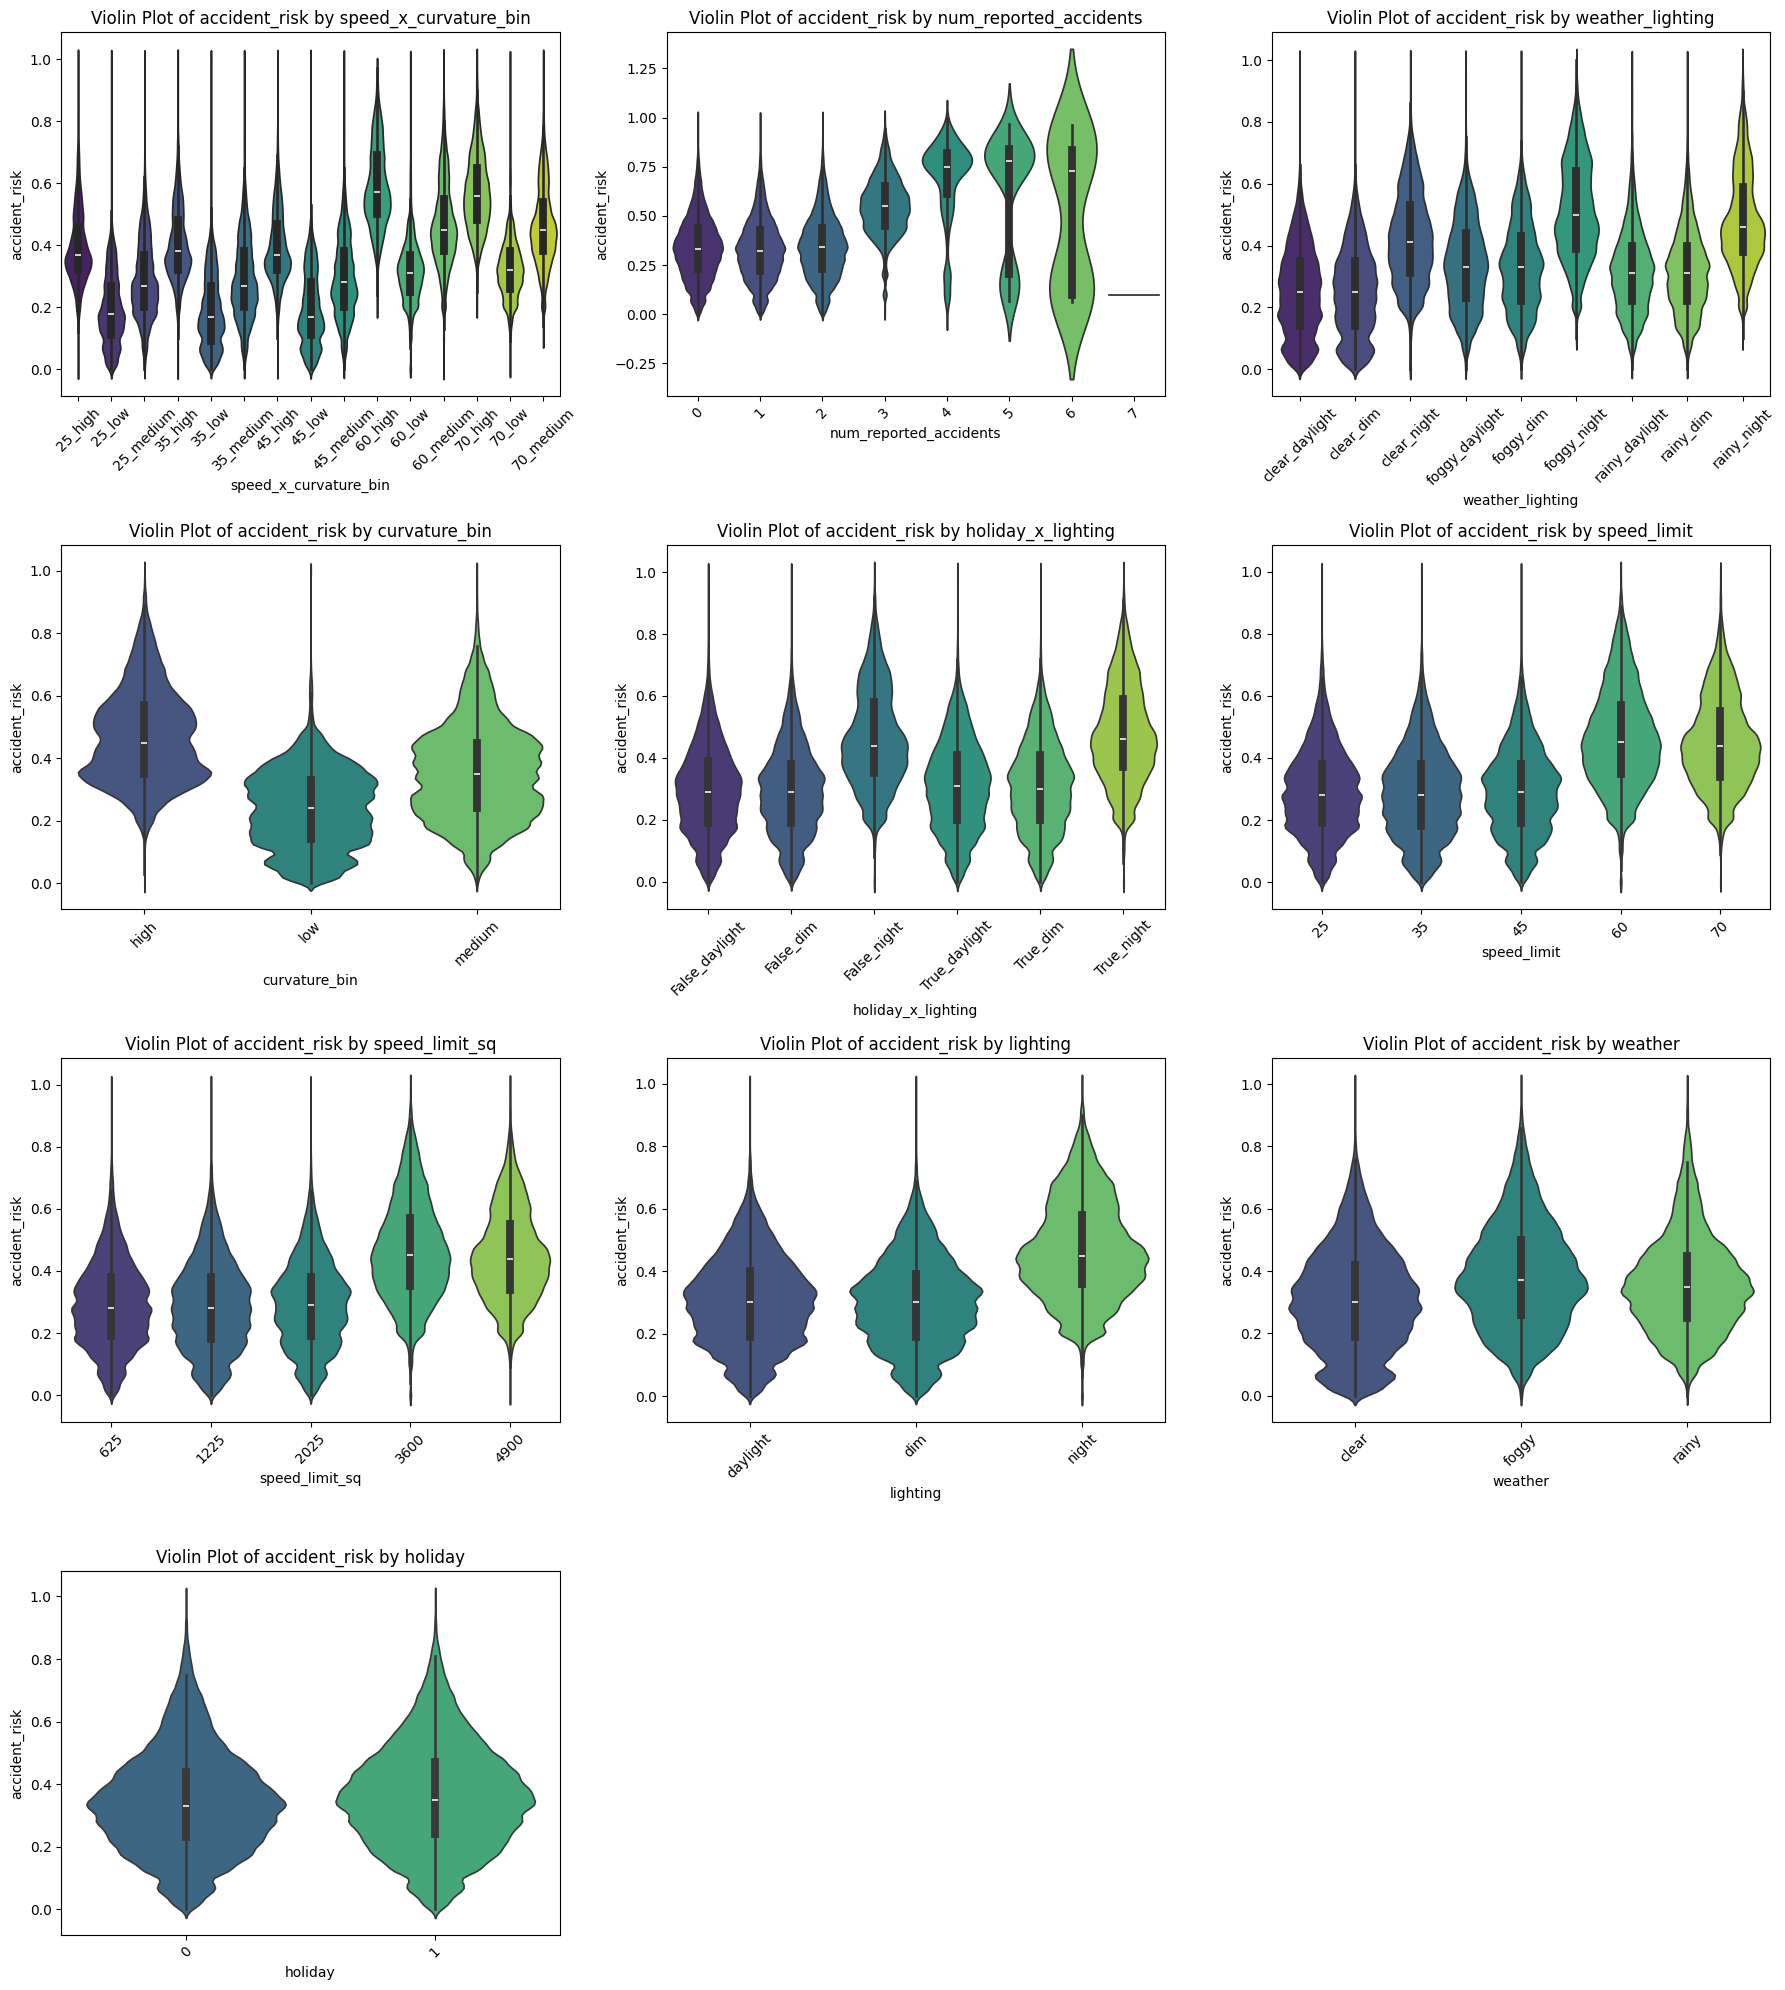

### Numeric × Categorical (Trend By Category)

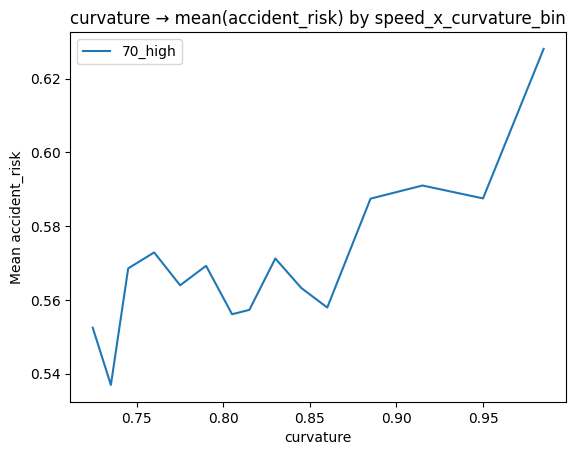

### Categorical × Categorical (Heatmap)

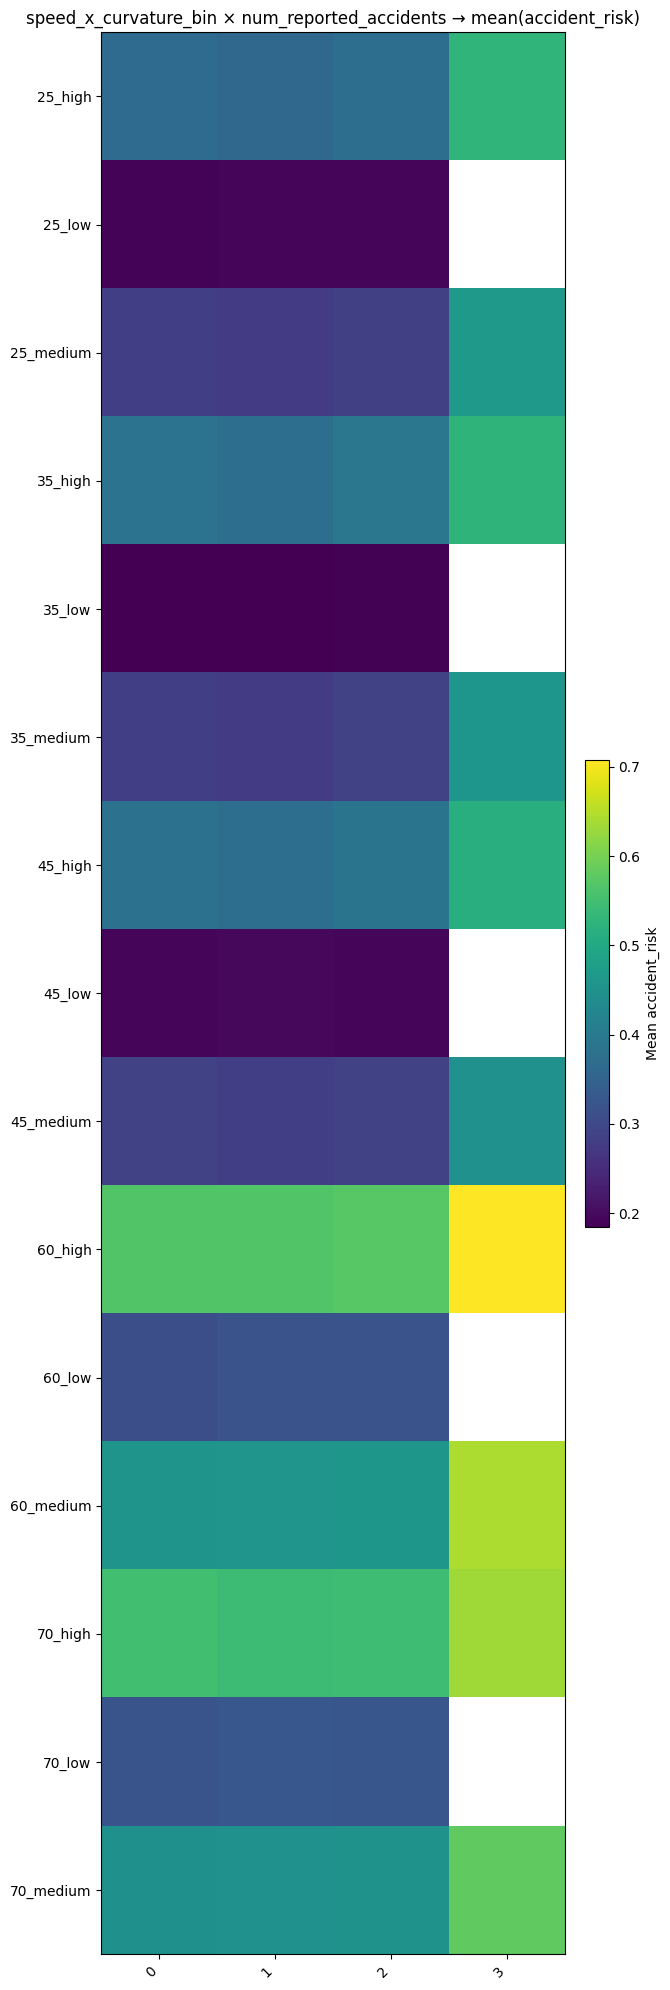

### Numeric × Numeric (Hexbin Target Mean)

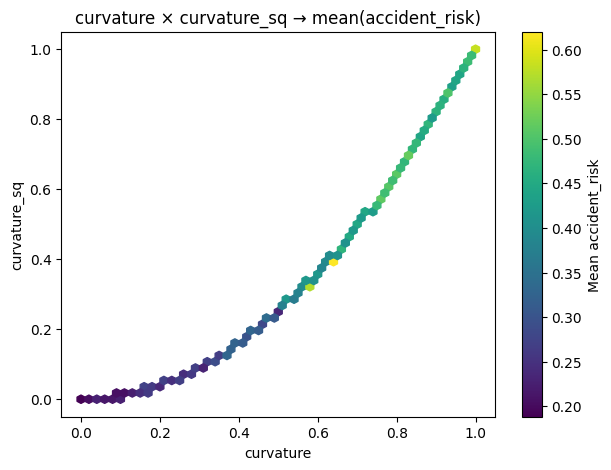

### Time of Day vs Risk Line

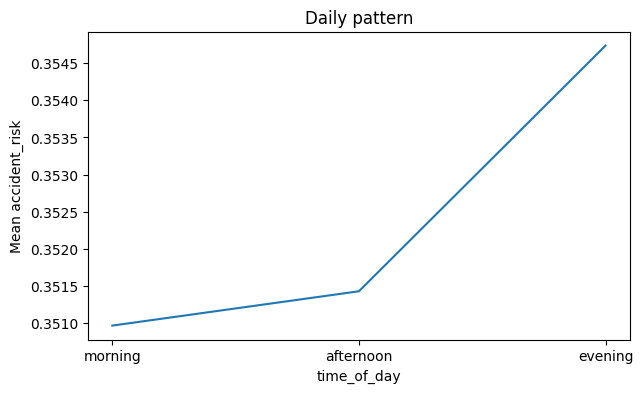

### Feature Signal Ranking

Top numeric (|Spearman|): [('curvature', 0.5467742572078576), ('curvature_sq', 0.5467742572078576), ('speed_limit', 0.40914437276337084), ('speed_limit_sq', 0.40914437276337084), ('speed_curvature_ratio', -0.2761365281476622), ('num_reported_accidents', 0.15426290391245698), ('holiday', 0.05408739499370716), ('public_road', 0.03242224313333117), ('num_lanes', -0.007230978036206295), ('school_season', 0.00020409075203305712)]
Top categorical (range of mean risk): [('speed_x_curvature_bin', 0.40440440054076254, 15), ('weather_lighting', 0.26591526382344943, 9), ('curvature_bin', 0.2321141762849627, 3), ('holiday_x_lighting', 0.18407480942020282, 6), ('lighting', 0.1703579791069305, 3), ('weather', 0.07624463499104406, 3), ('road_type', 0.007721712947188375, 3), ('time_of_day', 0.003769930463624338, 3)]


In [39]:
run_eda(X_training, target = TARGET)

In [40]:
profile = ProfileReport(X_training, title="Engineered Training EDA Report")
profile.to_file("engineered_training_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.84it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
# Display the HTML report in an iframe
IFrame(src='engineered_training_report.html', width=1000, height=600)

In [42]:
X_training.drop(TARGET, axis=1, inplace=True)

## Model Training

### Define, Train, and Evaluate the LightGBM Model

In [ ]:
# Hyperparameter tuning with Optuna
try:
    from optuna.integration import LightGBMPruningCallback
except ImportError:  # pragma: no cover
    LightGBMPruningCallback = None

print("Running Optuna hyperparameter tuning...")

train_df_featured = feature_engineer(training_df, drop_duplicates = DROP_TRAINING_DUPLICATES)
test_df_featured = feature_engineer(test_df, drop_duplicates = False)

y = train_df_featured[TARGET]
X = train_df_featured.drop(columns=['id', TARGET], errors='ignore')

N_SPLITS = 5

def safe_stratify_bins(y: pd.Series, max_q: int = 12, min_q: int = 5, n_splits: int = N_SPLITS) -> np.ndarray:
    """Return integer labels for stratification; adapt q downward until all bins have ≥ n_splits."""
    q = max_q
    while q >= min_q:
        bins = pd.qcut(y, q=q, duplicates="drop", labels=False)
        # drop NaNs if any (can happen if duplicates dropped)
        bins = pd.Series(bins, index=y.index)
        if bins.isna().any():
            q -= 1
            continue
        counts = bins.value_counts()
        if counts.min() >= n_splits:
            return bins.values
        q -= 1
    # fallback: plain KFold-style stratification on coarse bins
    return pd.qcut(y, q=min_q, duplicates="drop", labels=False).fillna(0).astype(int).values

y_binned = safe_stratify_bins(y, max_q=12, min_q=5, n_splits=N_SPLITS)

device_params = resolve_lgb_device(USE_GPU, X, y)
print(f"USE_GPU = {USE_GPU}; device_params={device_params}")

def objective(trial: optuna.Trial) -> float:
    params = {
        'objective': 'rmse',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': 10000,
        'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.013, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 50, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.60, 0.80),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.60, 0.80),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 3),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.05, 0.3, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.05, 0.3, log=True),
        'verbose': -1,
        'n_jobs': -1,
        'seed': seed,
        **device_params,
    }

    folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
    oof = np.zeros(len(X), dtype=float)
    best_iters = []

    for tr_idx, va_idx in folds.split(X, y_binned):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        model = lgb.LGBMRegressor(**params)

        callbacks = []
        if LightGBMPruningCallback is not None:
            callbacks.append(LightGBMPruningCallback(trial, 'rmse'))
        callbacks.append(lgb.early_stopping(1000, verbose=False))  # more patience during tuning

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='rmse',
            categorical_feature=categorical_features,
            callbacks=callbacks,
        )
        best_iters.append(model.best_iteration_)
        oof[va_idx] = model.predict(X_va)

    rmse = float(np.sqrt(mean_squared_error(y, oof)))
    trial.set_user_attr('avg_best_iteration', float(np.mean(best_iters)))
    return rmse
    
pruner = optuna.pruners.PatientPruner(
    optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=500),
    patience=3
)
study = optuna.create_study(
    study_name="lgb_road_risk_optuna",
    direction='minimize',
    sampler=TPESampler(seed=seed, n_startup_trials=20, multivariate=True, group=True),
    pruner=pruner
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

best_iteration = int(study.best_trial.user_attrs.get('avg_best_iteration', 20000))

print(f"Best RMSE: {study.best_value:.6f}")
print(f"Average best iteration during tuning: {best_iteration}")
print("Best parameters:")
print(study.best_trial.params)

lgb_params_tuned = {
    **study.best_trial.params,
    'objective': 'rmse',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators': 20000,
    'verbose': -1,
    'n_jobs': -1,
    'seed': seed,
    **device_params,
}
optuna_best_iteration = int(study.best_trial.user_attrs.get('avg_best_iteration', 20000))


Running Optuna hyperparameter tuning...


[I 2025-10-19 12:27:41,888] A new study created in memory with name: lgb_road_risk_optuna


USE_GPU = True; device_params={'device_type': 'gpu', 'gpu_platform_id': -1, 'gpu_device_id': -1}


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-19 12:33:35,452] Trial 0 finished with value: 0.056033281670932224 and parameters: {'learning_rate': 0.011469354978439022, 'num_leaves': 72, 'feature_fraction': 0.7826032233385651, 'bagging_fraction': 0.7504725073679623, 'bagging_freq': 1, 'lambda_l1': 0.19679504898312053, 'lambda_l2': 0.2985048280572631}. Best is trial 0 with value: 0.056033281670932224.


In [ ]:
# Cross-validated training with tuned parameters
print("Evaluating tuned parameters with cross-validation...")

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
oof_preds = np.zeros(X.shape[0], dtype=float)
best_iterations = []

for n_fold, (tr_idx, va_idx) in enumerate(folds.split(X, y_binned)):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    model = lgb.LGBMRegressor(**lgb_params_tuned)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        callbacks=[lgb.early_stopping(300, verbose=True)],
    )

    best_iterations.append(model.best_iteration_)
    oof_preds[va_idx] = model.predict(X_va)

    fold_rmse = np.sqrt(mean_squared_error(y_va, oof_preds[va_idx]))
    print(f"Fold {n_fold + 1} RMSE: {fold_rmse:.6f}")
    print(f"  -> Best Iteration: {model.best_iteration_}")

optimal_estimators = int(np.mean(best_iterations))
overall_rmse = np.sqrt(mean_squared_error(y, oof_preds))

print("\n" + "=" * 40)
print(f"Overall CV RMSE: {overall_rmse}")
print(f"Average best iteration across all folds: {optimal_estimators}")
print("=" * 40 + "\n")


In [ ]:
# Update the parameters for the final model
final_model_params = lgb_params_tuned.copy()
final_estimators = optimal_estimators if optimal_estimators > 0 else optuna_best_iteration
final_model_params['n_estimators'] = max(50, final_estimators)

print(f"Training the final model on the entire dataset with {final_model_params['n_estimators']} estimators...")

final_model = lgb.LGBMRegressor(**final_model_params)

train_df_featured = feature_engineer(training_df, drop_duplicates = DROP_TRAINING_DUPLICATES)

y = train_df_featured[TARGET].copy()
X = train_df_featured.drop(columns=['id', TARGET], errors='ignore')

final_model.fit(
    X,
    y,
    eval_set=[(X, y)],
    categorical_feature=categorical_features,
    eval_metric='rmse',
    callbacks=[lgb.log_evaluation(period=100)],
)

print("Final model training complete.")


In [ ]:
print("Calculating score on original dataset")

original_df_featured = feature_engineer(original_df, drop_duplicates = DROP_TRAINING_DUPLICATES)

# Prepare DataFrames for the the prediction
y = original_df_featured['accident_risk']
X = original_df_featured.drop(columns=['id', 'accident_risk'], errors='ignore')

# Get the predictions
y_preds = final_model.predict(X)

original_rmse = np.sqrt(mean_squared_error(y, y_preds))
print(f"Original Dataset CV RMSE: {original_rmse}")

## Prepare Submission

In [ ]:
print("Preparing the submission")

# Ready the data for prediction
X_test = X_test.drop(columns=[TARGET, "id"], errors="ignore")

# Convert categorical columns to the 'category' dtype for LightGBM
for col in categorical_features:
    X_test[col] = X_test[col].astype('category')
    
# Generate the predictions
test_preds = final_model.predict(X_test)

# Add back the IDs and write to CSV
submission = pd.DataFrame({"id": test_ids, "accident_risk": test_preds})
display(submission.head())

submission.to_csv("submission.csv", index = False)
print("Saved submission.csv")